# Sampling a Straight Line  with a Hamiltonian Monte Carlo (HMC)
## 1) Writing out the Bayes' theorem formulation of problem
Remembering the simple form of a straight line, y = mx + b, we can create the Bayes' theorem formulation of this. A good way to develop some intuition for Bayesian statistics is to think about Bayes' theorem as a way of updating your prior based on data. Your prior describes what you think the distribution of your parameters is. We start with Bayes' theorem:

$$p(A|B) = \frac{p(B|A) p(A)}{p(B)},$$
where p(A|B) is the posterior, p(B|A) is the likelihood, p(A) is the prior, and p(B) is the evidence.  
In a more intuitive way, we can write it as:
$$p(\textrm{theory relation|my data}) = \frac{p(\textrm{data|theory relation}) p(\textrm{theory relation})}{p(\textrm{data})}.$$ Theory relation here really represents a model for our data that says something about our universe.

### Bayes' Theorem for our problem
$$p(m, b|y) = \frac{p(y|m,b) p(m, b)}{p(y)}$$


Finally, let's go through eterimining the likelihood and prior for our problem. You may wonder, wait, what happened to the evidence? We can actually think of the evidence as a normalizing factor and can leave it off to make writing up our posterior easier. Remember we can easily normalize post sampling our posterior since remember. The evidence really just allows our posterior to integrate to 1, i.e., normalized!


### Wait, where's the data? 
Our plan of attack is to generate some noisy data around the actual values for a straight line where m = 1 and b = -2 to use as our data. We'll be sampling different values of m and b in our MCMC (described in 2), but note that we are NOT fitting for our data like you might do in a least squares problem. We'll use the evaluations from the MCMC to help us infer these parameters

### Prior: p(m, b)
We can assume a gaussian prior for our distributions centered at 0, i.e., 

$$p(m, b) = \frac{1}{2 \pi \sigma_m \sigma_b} e^{\frac{-m^2}{2 \sigma_m^2}} e^{\frac{-b^2}{2 \sigma_b^2}}.$$

Remember we have an uncorrelataed prior so we can multiple the two gaussian distributions for b and m together easily. 

### Likelihood: p(y|m,b)

Now onto the likelihood. Honestly, this is always the trickiest part for me to think about probably because I'm not a theorist. When thinking about the values of the likelihood, we need to remember that because of the sign of the likelihood, the closer the values are to 0 (the less negative) the more likely this theorist relation or model is. 

Our theoretical likelihood is a dirac delta (i.e., equal to infinity when its argument is 0 and equal to 0 everywhere else):
$$p(y|m,b) = \delta^D (y - (mx + b)).$$ 

However, this only works if our data is perfect with no errors which never happens. We instead need to use a gaussian distribution to model this type of likelihood.

$$\lim_{\sigma \to 0} \frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-x^2}{2\sigma^2}} = \delta^{D}(x).$$

So if we take our gaussian $\sigma$ value to 0, centered at our model value (mx+b), we will end up with a dirac delta. Therefore, we can write our likelihood as follows for ONE y value:

$$p(y|m,b) = \frac{1}{\sigma_y \sqrt{2\pi}} e^{\frac{-[y - (mx + b)]^2}{2 \sigma_y^2}}.$$

Our $\sigma_y$ describes the gaussian distribution of the y value. Wait but we're going to need to calculate the log-likelihood for all the y values for a given m and b, we need a sum since the log-likelihood should be a value not an array.

$$p(y|m,b) = \frac{1}{(2 \pi \sigma_y^2)^{n/2}} e^{\frac{-\sum_{i=1}^{n}[y_i - (mx_i + b)]^2}{2 \sigma_y^2}},$$

where n is the length of the array (remembering that Python arrays start indexing at 0).


Note: Be careful about confusing the prior with the posterior, especially the standard deviations (as I have done before). Remember the prior describes what you think the distribution of the parameters you want to know are. The likelihood describes the probability distribution of the model matching the data.

### Alas, the logged thing we will sample!
Okay, now let's log everything and see what we're left with for our not normalized posterior (remember we're not including the evidence). 
$$\log{p(y|m,b)} = \log\left[\frac{1}{2 \pi \sigma_m \sigma_b} \frac{1}{(2 \pi \sigma_y^2)^{n/2}}\right] + \left[ \frac{-\sum_{i=1}^{n}[y_i - (mx_i + b)]^2}{2 \sigma_y^2} + \frac{-m^2}{2 \sigma_m^2} + \frac{-b^2}{2 \sigma_b^2} \right]$$

$$\log{p(y|m,b)} = \log\left[\frac{1}{2 \pi \sigma_m \sigma_b} \frac{1}{(2 \pi \sigma_y^2)^{n/2}}\right] - \left[ \frac{\sum_{i=1}^{n}[y_i - (mx_i + b)]^2}{2 \sigma_y^2} + \frac{m^2}{2 \sigma_m^2} + \frac{b^2}{2 \sigma_b^2} \right]$$

### Gradients (if using a Hamiltonian Monte Carlo (HMC))
#### derivative of log-likelihood with respect to m:
$$\frac{d\log{p(y|m,b)}}{dm} = - \left[\frac{\sum_i[y_i - (m x_i + b)][- x_i]}{\sigma_y^2} + \frac{m}{\sigma_m^2}\right]$$

#### derivative of log-likelihood with respect to b:
$$\frac{d\log{p(y|m,b)}}{db} = - \left[\frac{\sum_i[-y_i + (m x_i + b)]}{\sigma_y^2} + \frac{b}{\sigma_b^2}\right]$$


## 2) Sampling from our posterior
Here's the fun part! Where the Monte Carlo Markov Chain (MCMC) does the difficult work for us by sampling our posterior. Note that many MCMC algorithms take in what they call the log-likelihood. This is the logged version of your likelihood and your prior. It should really be called the $\textbf{logged not normalized posterior}$, but you'll hear log-likelihood interchanged for this quite often. Let's start by writing a function to return our numeric log likelihood.

In [1]:
import numpy as np
import pyhmc
import matplotlib.pyplot as plt
import corner
%matplotlib inline

In [2]:
def log_posterior(m, b, data_ys, data_xs, sigma_b, sigma_m, sigma_y):
    """
    This function returns the log posterior for a straight line.
    
    Parameters
    ----------
    data_ys: y values that we're trying to figure out the straight line parameters for
    data_xs: x values that correspond to our x values
    m: slope of line
    b: y-intercept of line
    sigma_b: standard deviation of gaussian distribution prior describing b
    sigma_m: standard deviation of gaussian distribution prior describing m
    sigma_y: standard deviation of gaussian distribution describing y data values
    
    Returnssu
    ----------
    log_posterior evaluated at given parameters above, constants for gradient
    """
    n = len(data_ys) # length of data set
    log_constant_prior = -np.log(2*np.pi*sigma_m*sigma_b)
    log_constant_likely = -(n/2)*np.log((2*np.pi*(sigma_y**2)))
    constants = log_constant_prior + log_constant_likely
    
    sum_likelihood = np.sum((data_ys-(m*data_xs+b))**2)
    log_likely = (sum_likelihood)/(2*sigma_y**2)
    log_prior = 0.5*((m/sigma_m)**2 + (b/sigma_b)**2)
    sum_likely_prior = log_likely + log_prior
    final_log_sum = constants - sum_likely_prior
    return final_log_sum, constants

In [3]:
def gradients(data_ys, data_xs, m, b, sigma_m, sigma_b, sigma_y):
    """
    This function returns the gradient of the log likelihood for fitting a straight line.
    
    Parameters
    ----------
    data_ys: y values that we're trying to figure out the straight line parameters for
    data_xs: x values that correspond to our x values
    m: slope of line
    b: y-intercept of line
    sigma_b: standard deviation of gaussian distribution prior describing b
    sigma_m: standard deviation of gaussian distribution prior describing m
    sigma_y: standard deviation of gaussian distribution describing y data values
    
    Returns
    ----------
    [m gradient, b gradient]
    
    """
    b_sums = np.sum(m*data_xs + b - data_ys)/(sigma_y**2)
    b_gradient = -(b_sums + (b/sigma_b**2))
    m_sums = np.sum(data_xs*(m*data_xs + b - data_ys))/(sigma_y**2)
    m_gradient = -(m_sums + (m/sigma_m**2))

    return np.asarray([m_gradient, b_gradient])

In [4]:
def sample_this(params, data_ys, data_xs, sigma_m, sigma_b, sigma_y):
    m = params[0]
    b = params[1]
    final_log_sum, constants = log_posterior(m, b, data_ys, data_xs, sigma_b, sigma_m, sigma_y)
    grads = gradients(data_ys, data_xs, m, b, sigma_b, sigma_m, sigma_y)
    return final_log_sum, grads

Text(0.5, 1.0, 'messy data!')

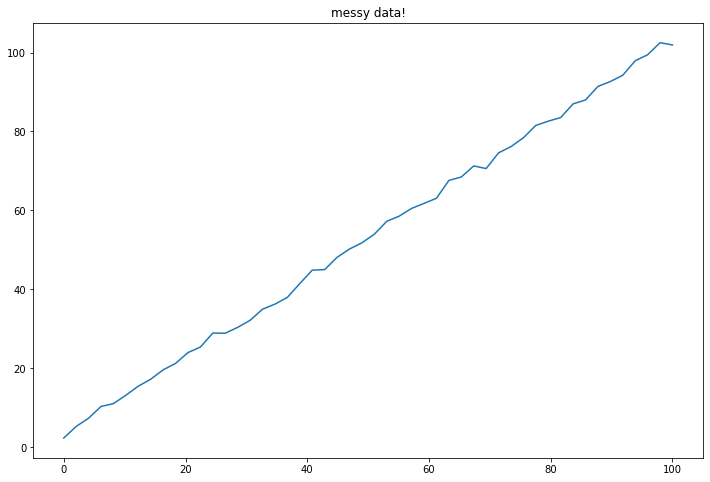

In [5]:
m_actual = 1
b_actual = 3
sigma_y = 1
data_xs = np.linspace(0, 100)
data_ys = m_actual*data_xs + b_actual
noise = np.random.normal(loc=0.0, scale=sigma_y, size = len(data_ys))
data_ys = data_ys + noise

plt.figure(figsize=(12,8))
plt.plot(data_xs, data_ys)
plt.title("messy data!")

In [13]:
pyhmc.hmc?

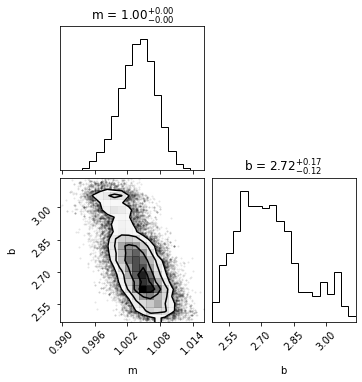

In [7]:
# Now, let's set our sigma values that describe the prior and likelihood gaussian distributions
sigma_m, sigma_b = 4, 4

samples = pyhmc.hmc(sample_this, x0=[1, 3], args=(data_ys, data_xs, sigma_m, sigma_b, sigma_y), n_samples=int(5e4), epsilon = 0.0044, return_diagnostics=True)
figure = corner.corner(samples[0], labels=["m", "b"], show_titles=True, title_kwargs={"fontsize": 12})
# plt.savefig("sample_rate_0.0044.png", facecolor='w')

## 3) Optimizing hyperparameters
We have to be careful with the step size in our integration, i.e., epsilon. You can think of this as the time step in the equations of motion that we're integrating with the HMC. It's very sensitive to the size of your data set so we'll try and constrain the epsilon values to a rejection rate of a bout 0.5.

In [14]:
acceptance_rates = []
i = 0
for eps in np.linspace(0.001, 0.025, 10):
    i += 1
    hmc_output = pyhmc.hmc(sample_this, x0=[1.5, 2.5], args=(data_ys, data_xs, sigma_m, sigma_b, sigma_y), n_samples=int(1e4), epsilon = eps, return_diagnostics=True, return_logp=True)
    acceptance_rates.append(hmc_output[2]["rej"])

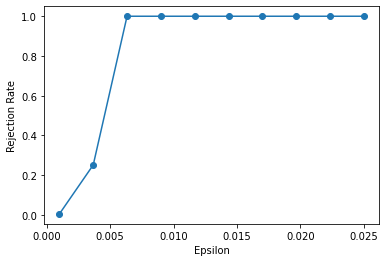

In [15]:
plt.close()
epsilons = np.linspace(0.001, 0.025, 10)
plt.plot(epsilons, acceptance_rates, marker = 'o')
plt.xlabel("Epsilon")
plt.ylabel("Rejection Rate")
plt.savefig("hyperparameter_op.png", facecolor='w')

## 4) Plotting the analytic posterior
Wait, but we have such a simple problem. We can actually plot the analytic version of the posterior for a finaly tuned m and b array. Let's see what that looks like below

Text(0, 0.5, 'b')

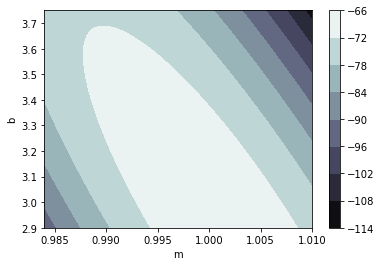

In [17]:
posteriors = []
m_arr = np.linspace(0.984, 1.01, 100)
b_arr = np.linspace(2.9, 3.75, 100)

X, Y = np.meshgrid(m_arr, b_arr)
sh = np.shape(X)
fig, ax = plt.subplots()

Z = np.empty(shape=sh)
for i in range(sh[0]):
    for j in range(sh[1]):

        Z[i][j] = log_posterior(X[i][j], Y[i][j], data_ys, data_xs, sigma_b, sigma_m, sigma_y)[0]
cs = ax.contourf(X, Y, Z, cmap=plt.cm.bone)
cbar = fig.colorbar(cs)
ax.set_xlabel("m")
ax.set_ylabel("b")

This looks similar to the posteriors we sampled with the HMC. Why is the posterior so long and skinny however? The larger our "messy" data set is, we'll see that this posterior becomes skinnier. You can think about it as small changes in slope values (m) will have change the posterior more for a larger data set. Looking at the contour plot, stepping from gray to light bluish (the next color in the color bar) we're looking at 6 orders of magnitude of a change in the log posterior. This was a trickier problem than we thought, but a great example of a new statistical model that hopefully illustrates its intricacies well.